In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import torchvision
import torch
import timm
import random
from PIL import Image
from IPython.display import display


C:\Users\Admin\.conda\envs\neural_ODE\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [3]:
PATH = os.curdir

cfn_file = os.path.join(PATH, 'saved_cfn.pth')
conv_file = os.path.join(PATH,'saved_conv2.pth')
jigsaw_model_file = os.path.join(PATH, 'saved_jigsaw_model.pth')
permuts_file = os.path.join(PATH, 'permuts.npy')

cfn_file

'.\\saved_cfn.pth'

In [4]:
from torch.utils.data import ConcatDataset, DataLoader, Dataset, random_split
from torchvision import datasets, transforms


Image_dataset = torchvision.datasets.CIFAR10(
    root='./data', train=True, download=True)

test_set = torchvision.datasets.CIFAR10(
    root='./data', train=False, download=True)

Image_dataset =  ConcatDataset([Image_dataset, test_set])

train_dataset, pretrain_dataset, test_dataset = random_split(Image_dataset, [0.05, 0.45, 0.5])

Files already downloaded and verified
Files already downloaded and verified


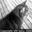

3

In [5]:
img, label = pretrain_dataset.__getitem__(0)
#img = img.resize((256,256))
display(img)
label

In [6]:
#defining some functions
def get_nine_crops(pil_image):
    """
    https://github.com/aniket03/self_supervised_bird_classification/blob/master/get_dataset.py
    
    Get nine crops for a square pillow image. That is height and width of the image should be same.
    :param pil_image: pillow image
    :return: List of pillow images. The nine crops
    """
    w, h = pil_image.size
    diff = int(w/3)

    r_vals = [0, diff, 2 * diff]
    c_vals = [0, diff, 2 * diff]

    list_patches = []

    for r in r_vals:
        for c in c_vals:

            left = c
            top = r
            right = c + diff
            bottom = r + diff

            patch = pil_image.crop((left, top, right, bottom))
            list_patches.append(patch)

    return list_patches

def rearrange(nine_crop, permut):
    X= nine_crop
    Y= permut
    sorted_indices = sorted(range(len(Y)), key=lambda k: Y[k])
    reordered_crops = [X[i] for i in sorted_indices]
    return reordered_crops

def generate_permuts(array_len = 9, permuts_to_take= 64):
    
    #https://github.com/aniket03/self_supervised_bird_classification/blob/master/get_top_x_permutations.py
    import itertools
    import random
    import numpy as np

    from scipy.spatial.distance import hamming


    # Build list of all possible permutations
    permuts_list = list(itertools.permutations(range(array_len)))
    permuts_array = np.array(permuts_list)
    no_permuts = len(permuts_list)


    # Take top x permutations which have max average hamming distance
    set_of_taken = set()
    cnt_iterations = 0
    while True:
        cnt_iterations += 1
        x = random.randint(1, no_permuts - 1)
        y = random.randint(1, no_permuts - 1)
        permut_1 = permuts_array[x]
        permut_2 = permuts_array[y]
        hd = hamming(permut_1, permut_2)

        if hd > 0.9 and (not x in set_of_taken) and (not y in set_of_taken):
            set_of_taken.add(x)
            set_of_taken.add(y)

            if len(set_of_taken) == permuts_to_take:
                break

        if cnt_iterations % 100 == 0:
            print ("Already performed count of iterations with pairs of jigsaw permutations", cnt_iterations)
            print ("Length of set of taken: ",len(set_of_taken))

    print ("No of iterations it took to build top - {} permutations array = {}".format(permuts_to_take, cnt_iterations))
    print ("No of permutations", len(set_of_taken))


    # Build the array for selected permutation indices above
    selected_permuts = []
    for ind, perm_id in enumerate(set_of_taken):
#         if ind < 10:
#             print ("Sample permutation {}".format(ind))
#             print (permuts_array[perm_id])
        selected_permuts.append(permuts_array[perm_id])

    selected_permuts = np.array(selected_permuts)
#     np.save('selected_permuts.npy', selected_permuts)

    return selected_permuts

In [7]:
#generating 64 possible permuts
nine_crops = get_nine_crops(img)
permuts = generate_permuts()
classes, _ = permuts.shape

No of iterations it took to build top - 64 permutations array = 95
No of permutations 64


In [8]:
#saving and loading permuts
np.save( permuts_file, permuts)
permuts = np.load(permuts_file)

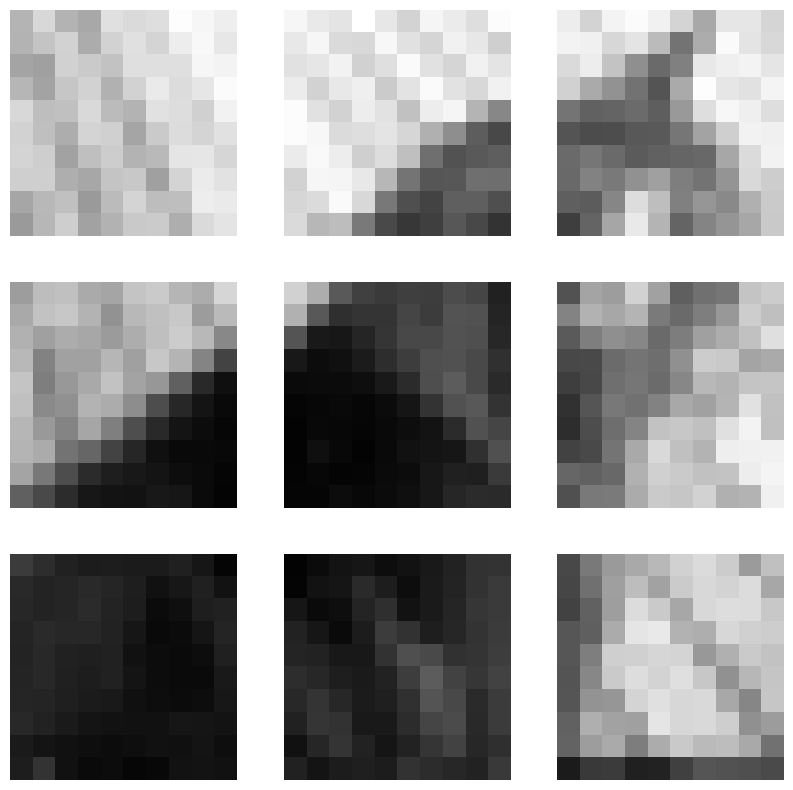

In [9]:
#before shuffling

from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

rows = 3
cols = 3
figsize=(10, 10)

fig, axes = plt.subplots(rows, cols, figsize=figsize)

for i in range(rows):
    for j in range(cols):
        ax = axes[i, j]
        ax.axis("off")

        # Check if there are more images to display
        index = i * cols + j
        if index < len(nine_crops):
            ax.imshow(np.asarray(nine_crops[index]))

plt.show()


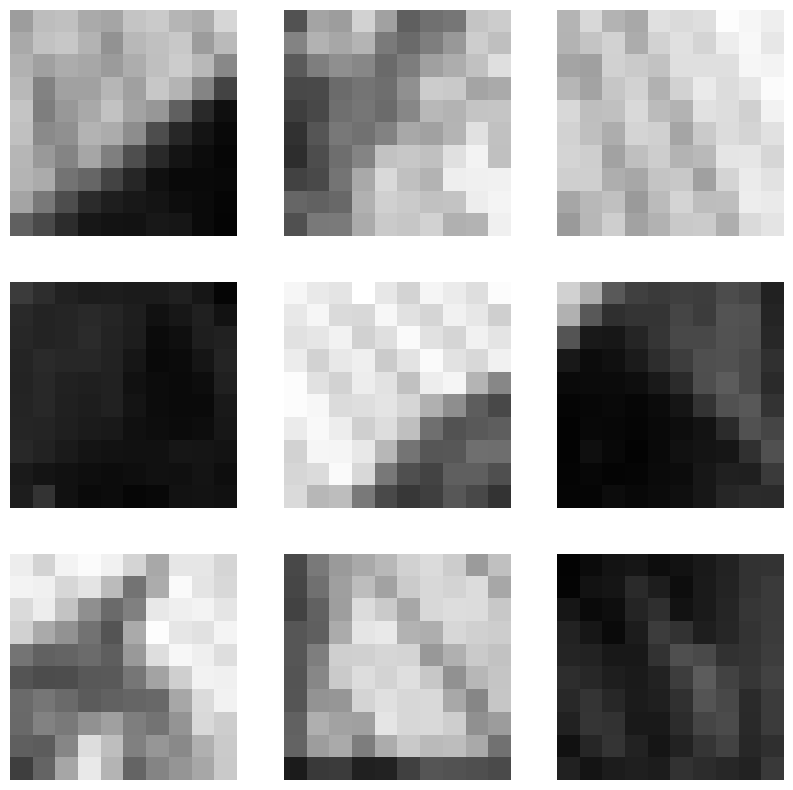

In [10]:
#after shuffling
nine_crops = rearrange(nine_crops, permuts[0])

fig, axes = plt.subplots(rows, cols, figsize=figsize)

for i in range(rows):
    for j in range(cols):
        ax = axes[i, j]
        ax.axis("off")

        # Check if there are more images to display
        index = i * cols + j
        if index < len(nine_crops):
            ax.imshow(np.asarray(nine_crops[index]))


plt.show()


# Pretraining

In [11]:
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

class JigsawDataset(Dataset):
    def __init__(self, dataset, permuts, no_of_jigs):        
        self.dataset = dataset
        self.permuts = permuts
        self.no_of_jigs = no_of_jigs 

    def __len__(self):
        return self.dataset.__len__() * self.no_of_jigs # 69 average jigsaw per image (in paper)
    
    def __getitem__(self, index):
        index = int(index / self.no_of_jigs)
        img, _ = self.dataset.__getitem__(index)
        
        nine_crops = get_nine_crops(img)
        
        r = random.randint(0, len(permuts) -1 )
        nine_crops = rearrange(nine_crops, permuts[r])
        
        transform = transforms.ToTensor()
        
        image_list = []
        for i in range(9):
            #print(transform(nine_crops[i]).shape)
            #image_list = torch.concat((image_list, transform([nine_crops[i]])), dim = 0)
            image_list.append(transform(nine_crops[i]))
        
        image_list = torch.stack(image_list, dim = 0)
        return image_list, r
    


In [12]:
Jig_Dataset =  JigsawDataset(pretrain_dataset, permuts, no_of_jigs= 20)
# Jig_Dataset.__len__()
#Jig_Dataset.__getitem__(2)

pretrain_loader = DataLoader(Jig_Dataset, batch_size = 128, shuffle =True)

# train_features, train_labels = next(iter(pretrain_loader))
# print(len(train_features))


### CFN Model

In [13]:
import torch
import torch.nn as nn
from torch import cat
import torch.nn.init as init

#https://github.com/bbrattoli/JigsawPuzzlePytorch/blob/master/JigsawNetwork.py

class Network(nn.Module):

    def __init__(self, classes=64):
        super(Network, self).__init__()

        self.conv = timm.create_model('efficientnet_b0', pretrained=False)  # Set pretrained to False
        self.conv = nn.Sequential(*(list(self.conv.children())[:-1]))
        
        self.fc6 = nn.Sequential()
        self.fc6.add_module('fc6_s1',nn.Linear(1280, 1024)) #256*3*3
        self.fc6.add_module('relu6_s1',nn.ReLU(inplace=True))
        self.fc6.add_module('drop6_s1',nn.Dropout(p=0.5))

        self.fc7 = nn.Sequential()
        self.fc7.add_module('fc7',nn.Linear(9*1024,4096))
        self.fc7.add_module('relu7',nn.ReLU(inplace=True))
        self.fc7.add_module('drop7',nn.Dropout(p=0.5))

        self.classifier = nn.Sequential()
        self.classifier.add_module('fc8',nn.Linear(4096, classes))
        
        #self.apply(weights_init)

    def load(self,checkpoint):
        model_dict = torch.load(checkpoint)
        self.load_state_dict(model_dict)

    def save(self,checkpoint):
        torch.save(self.state_dict(), checkpoint)
        
    def save_conv(self,checkpoint):                    
        torch.save(self.conv.state_dict(), checkpoint)   #to save only the convolutional weights
    
    def forward(self, x):
        B,T,C,H,W = x.size()
        x = x.transpose(0,1)

        x_list = []
        for i in range(9):
            z = self.conv(x[i])
            z = self.fc6(z.view(B,-1))
            z = z.view([B,1,-1])
            x_list.append(z)

        x = cat(x_list,1)
        x = self.fc7(x.view(B,-1))
        x = self.classifier(x)

        return x


In [14]:
CFN = Network()
#CFN.load_state_dict(torch.load(cfn_file))

In [15]:
#pretraining

import torch.optim as optim
from tqdm import tqdm


CFN.to(device)

loss_fn = nn.CrossEntropyLoss()
optimizer = optim.SGD(CFN.parameters(), lr=0.001, momentum=0.9)



for epoch in range(0):  # loop over the dataset multiple times
    loop = tqdm(pretrain_loader)  
    running_loss = 0.0
    for i, data in enumerate(loop):
        # get the inputs; data is a list of [inputs, labels]
        images, labels = data
        images = images.to(device)
        labels = labels.to(device)
        # zero the parameter gradients
        optimizer.zero_grad()
        
        # forward + backward + optimize
        outputs = CFN(images)
        loss = loss_fn(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
#         running_loss += loss.item()
        #if i % 200 == 199:    # print every 2000 mini-batches
#         print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
#         running_loss = 0.0
        loop.set_postfix(loss=loss.item())

print('Finished Training')



Finished Training


# Training

In [16]:
# add toTensor transform

class TransformedDataset(torch.utils.data.Dataset):
    def __init__(self, original_dataset, transform=None):
        self.original_dataset = original_dataset
        self.transform = transform

    def __getitem__(self, index):
        img, target = self.original_dataset[index]

        if self.transform:
            img = self.transform(img)

        return img, target

    def __len__(self):
        return len(self.original_dataset)

transform = transforms.Compose([
    transforms.ToTensor(),
])

train_dataset = TransformedDataset(train_dataset, transform= transform)
test_dataset = TransformedDataset(test_dataset, transform= transform)

test_loader = DataLoader(test_dataset, batch_size = 128, shuffle = True)
train_loader = DataLoader(train_dataset, batch_size = 256, shuffle = True)


In [17]:
def train_model(model, train_loader, criterion, optimizer, num_epochs=10, device='cuda'):
    """
    Function to train a PyTorch model.

    Parameters:
        - model: The PyTorch model to be trained.
        - train_loader: DataLoader for the training dataset.
        - criterion: Loss function.
        - optimizer: Optimization algorithm.
        - num_epochs: Number of training epochs.
        - device: Device to use ('cuda' or 'cpu').

    Returns:
        - model: Trained PyTorch model.
    """
    model.to(device)

    # Training loop
    for epoch in range(num_epochs):
        model.train()  # Set the model to training mode

        running_loss = 0.0
        correct_predictions = 0
        total_samples = 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)


            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            # Backward pass and optimization
            loss.backward()
            optimizer.step()

            # Update statistics
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_samples += labels.size(0)
            correct_predictions += (predicted == labels).sum().item()

        # Print statistics 
        epoch_loss = running_loss / len(train_loader)
        epoch_accuracy = correct_predictions / total_samples
        
        if epoch % 5 == 0:
            print(f'Epoch {epoch}/{num_epochs}, Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy * 100:.2f}%')
    print(f'Epoch {epoch + 1}/{num_epochs}, Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy * 100:.2f}%')
    return model


def validate_model(model, val_loader, criterion, device='cuda'):
    """
    Function to perform validation on a PyTorch model.

    Parameters:
        - model: The PyTorch model to be validated.
        - val_loader: DataLoader for the validation dataset.
        - criterion: Loss function.
        - device: Device to use ('cuda' or 'cpu').

    Returns:
        - accuracy: Accuracy on the validation dataset.
        - average_loss: Average loss on the validation dataset.
    """

    model.eval()  # Set the model to evaluation mode
    running_loss = 0.0
    correct_predictions = 0
    total_samples = 0

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            # Forward pass
            outputs = model(inputs)

            # Compute loss
            loss = criterion(outputs, labels)

            # Update statistics
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_samples += labels.size(0)
            correct_predictions += (predicted == labels).sum().item()

    # Calculate accuracy and average loss
    accuracy = correct_predictions / total_samples
    average_loss = running_loss / len(val_loader)

    print(f'Validation Accuracy: {accuracy * 100:.2f}%, Average Loss: {average_loss:.4f}')

    return accuracy, average_loss


## Using Imagnet Weights

In [18]:
Imagenet_model = timm.create_model('efficientnet_b0', pretrained=True)      #default EffecientNet weights trained on Imagenet data 

# Modify the last fully connected layer for CIFAR-10 (10 classes)
num_classes = 10
Imagenet_model.classifier = nn.Linear(Imagenet_model.classifier.in_features, num_classes)


criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(Imagenet_model.classifier.parameters(), lr=0.001, weight_decay = 0.001)

Imagenet_model = train_model(Imagenet_model, train_loader, criterion, optimizer, num_epochs = 50)
accuracy, average_loss =  validate_model(Imagenet_model, test_loader, criterion)

Epoch 0/50, Loss: 2.2831, Accuracy: 15.37%
Epoch 5/50, Loss: 1.5389, Accuracy: 49.90%
Epoch 10/50, Loss: 1.3351, Accuracy: 59.07%
Epoch 15/50, Loss: 1.1998, Accuracy: 62.20%
Epoch 20/50, Loss: 1.1209, Accuracy: 65.53%
Epoch 25/50, Loss: 1.0503, Accuracy: 67.93%
Epoch 30/50, Loss: 0.9974, Accuracy: 69.80%
Epoch 35/50, Loss: 0.9745, Accuracy: 69.20%
Epoch 40/50, Loss: 0.9331, Accuracy: 70.70%
Epoch 45/50, Loss: 0.9016, Accuracy: 71.87%
Epoch 50/50, Loss: 0.9185, Accuracy: 70.90%
Validation Accuracy: 30.53%, Average Loss: 2.2972


## Using Jigsaw Weights

In [19]:
Jigsaw_model = timm.create_model('efficientnet_b0', pretrained=False)  # Set pretrained to False
in_features = Jigsaw_model.classifier.in_features
Jigsaw_model = nn.Sequential(*(list(Jigsaw_model.children())[:-1]))

checkpoint = torch.load(conv_file)
Jigsaw_model.load_state_dict(checkpoint)

# Modify the classifier for your custom dataset
num_classes = 10
Jigsaw_model.add_module('classifier' , nn.Linear(in_features, num_classes))


# Optional: Fine-tune the model on your custom dataset
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(Jigsaw_model.classifier.parameters(), lr=0.001, weight_decay = 0.001)


Jigsaw_model = train_model(Jigsaw_model, train_loader, criterion, optimizer, num_epochs = 50)
accuracy, average_loss =  validate_model(Jigsaw_model, test_loader, criterion)

Epoch 0/50, Loss: 2.2842, Accuracy: 14.07%
Epoch 5/50, Loss: 2.1159, Accuracy: 23.93%
Epoch 10/50, Loss: 2.0596, Accuracy: 27.27%
Epoch 15/50, Loss: 2.0355, Accuracy: 28.37%
Epoch 20/50, Loss: 2.0294, Accuracy: 28.60%
Epoch 25/50, Loss: 1.9971, Accuracy: 30.37%
Epoch 30/50, Loss: 1.9808, Accuracy: 30.10%
Epoch 35/50, Loss: 1.9454, Accuracy: 32.97%
Epoch 40/50, Loss: 1.9665, Accuracy: 31.73%
Epoch 45/50, Loss: 1.9519, Accuracy: 32.67%
Epoch 50/50, Loss: 1.9604, Accuracy: 30.87%
Validation Accuracy: 20.87%, Average Loss: 2.2634
